# Google Cloud Next Expo Video Processing with Gemini 1.5 pro

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/almandsky/gcn_expo_walkthough_gemini_video/blob/main/notebook/Google_Cloud_Next_Expo_Video_Processing_with_Gemini_1_5_pro.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

This notebook is based on the [Gemini API: Prompting with Video](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Video.ipynb) notebook. We are using the Gemini 1.5 Pro to process the 46 minutes video of [Google Cloud Next 2024 Expo WALK through](https://youtu.be/sHjWg9hnK40?si=VW7nAp-xvzfJ14uJ) to analysis all the booths in the Expo, to give us some insights and statistics on the technical and business trend in the Cloud Computing eco system.

In [ ]:
!pip install -U -q google-generativeai

In [ ]:
import google.generativeai as genai

### Authentication Overview

**Important:** The File API uses API keys for authentication and access. Uploaded files are associated with the API key's cloud project. Unlike other Gemini APIs that use API keys, your API key also grants access data you've uploaded to the File API, so take extra care in keeping your API key secure. For best practices on securing API keys, refer to Google's [documentation](https://support.google.com/googleapi/answer/6310037).

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

## Extract frames

The Gemini API currently does not support video files directly. Instead, you can provide a series of timestamps and image files.

We will extract 2 frames a second (configurable) from the [Gemini API: Prompting with Video](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Video.ipynb) video.

Note: You can also [upload your own files](https://github.com/google-gemini/cookbook/tree/main/examples/Upload_files.ipynb) to use.

Use OpenCV to extract image frames from the video at N frame(s) per second.

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Replace the path and file name with the actual name of your video in Drive
video_file_name = '/content/drive/MyDrive/Google AI Studio/google_cloud_next_2024_full_expo.mov'


In [ ]:
import cv2
import os
import shutil

# Create or cleanup existing extracted image frames directory.
FRAME_EXTRACTION_DIRECTORY = "/content/frames"
FRAME_PREFIX = "_frame"

def create_frame_output_dir(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

def extract_frame_from_video(video_file_path, desired_fps=1):
    print(f"Extracting from {video_file_path} at {desired_fps} frame(s) per second. This might take a bit...")
    create_frame_output_dir(FRAME_EXTRACTION_DIRECTORY)
    vidcap = cv2.VideoCapture(video_file_path)
    actual_fps = vidcap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(actual_fps / desired_fps)  # Calculate the number of frames to skip
    output_file_prefix = os.path.basename(video_file_path).replace('.', '_')
    frame_count = 0
    count = 0

    while vidcap.isOpened():
        success, frame = vidcap.read()
        if not success:  # End of video
            break
        if count % frame_interval == 0:  # Capture frame at the interval of frame_interval
            milliseconds = int((count / actual_fps) * 1000) % 1000
            hours = (count // int(actual_fps)) // 3600
            minutes = ((count // int(actual_fps)) // 60) % 60
            seconds = (count // int(actual_fps)) % 60
            time_string = f"{hours:02}:{minutes:02}:{seconds:02}.{milliseconds:03}"
            image_name = f"{output_file_prefix}{FRAME_PREFIX}{time_string}.jpg"
            output_filename = os.path.join(FRAME_EXTRACTION_DIRECTORY, image_name)
            cv2.imwrite(output_filename, frame)
            frame_count += 1
        count += 1

    vidcap.release()
    print(f"Completed video frame extraction!\n\nExtracted: {frame_count} frames")


extract_frame_from_video(video_file_name, desired_fps=2)


Upload the frames go Google Drive, so that we don't need to process again next time.

In [ ]:
import shutil
source_folder = '/content/frames'
destination_folder = '/content/drive/My Drive/Google AI Studio/frames_480_2'  # Adjust the path as needed

# Copy the folder to Drive
shutil.copytree(source_folder, destination_folder)

## Generate Content

We will upload the files by batches, then make `GenerateContent` requests that reference the File API URI.

To understand videos with Gemini 1.5 Pro, provide 2 consecutive `Part`s for each frame: a `text` part with the **timestamp** and `fileData` part with the frame's **image URI**:

```
part { text = "00:00" }
part { fileData = fileData {
  fileUri = "https://generativelanguage.googleapis.com/v1/files/frame-0"
  mimeType = "image/jpeg"
}}
```

In [ ]:
# create the output folder
!mkdir output

In [ ]:
prompt = """

Please help to process the images from Google Cloud Next 2024 Expo, and capture the following info, then output in json:

The example value of the category are:

['Cloud Solutions', 'Database', 'Open Source', 'Cloud Networking', 'Hardware', 'Cloud Commerce', 'Consulting', 'Security', 'Cloud Storage', 'LegalTech', 'DevOps', 'Cloud Monitoring', 'FinOps', 'AI and Customer Experience', 'Data Management', 'Software', 'AI and Data Solutions', 'Developer Tools', 'Blockchain']


IMPORTANT: Please output only valid json.  Nothing else.


[
    {
        boothNumber: "The number of the booth",
        companyName: "Name of the company",
        category: "category of the company",
        summaryOfTheBooth: "Detailed summary for what's this company is doing. Try to capture as many as info as possible."
        businessModel: "Based on the message and text on the booth, try to analyze the business model.",
        numberOfPeople: "How many people are in front of the booth.  integer only.  if you don't know, put 0",
        startTimestamp: "timestamp of the first image file that this booth appeared.",
        endTimestamp: "timestamp of the last image file that this booth disappeared."
    },
    // another booth info
]

"""

In [ ]:
# define the batch size and starting batch number.
# We can update the batch_number to resume from the last successful batch, in case there is network error or API call failure.

batch_number = 1
batch_size = 1000
start_index = (batch_number - 1) * batch_size

In [ ]:
import os
import shutil

class File:
    def __init__(self, file_path: str, display_name: str = None):
        self.file_path = file_path
        if display_name:
            self.display_name = display_name
        self.timestamp = get_timestamp(file_path)

    def set_file_response(self, response):
        self.response = response

def get_timestamp(filename):
    parts = filename.split(FRAME_PREFIX)
    if len(parts) != 2:
        return None
    return parts[1].split('.')[0]

def process_files_in_batches(files, batch_size):
    for i in range(0, len(files), batch_size):
        batch_files = files[i:i + batch_size]
        yield batch_files

# Initialize directories and constants
FRAME_EXTRACTION_DIRECTORY = "/content/frames"
FRAME_PREFIX = "_frame"
# genai = None  # You need to set up your genai API client here
# Set the model to Gemini 1.5 Pro.
model = genai.GenerativeModel(model_name="models/gemini-1.5-pro-latest")

# Prepare files to upload
all_files = sorted(os.listdir(FRAME_EXTRACTION_DIRECTORY))
files_to_process = [File(os.path.join(FRAME_EXTRACTION_DIRECTORY, file)) for file in all_files]

# Batch processing



for files_batch in process_files_in_batches(files_to_process[start_index:], batch_size):
    print(f'Processing batch {batch_number} with {len(files_batch)} files.')

    # Upload files to the API
    for file in files_batch:
        print(f'Uploading: {file.file_path}...')
        response = genai.upload_file(path=file.file_path)
        file.set_file_response(response)

    # Create and send the generation request
    request = [prompt]
    for file in files_batch:
        request.append(file.timestamp)
        request.append(file.response)
    response = model.generate_content(request, request_options={"timeout": 600}, generation_config={"temperature": 0.1})
    print(response)
    # Save the response to a local file
    with open(f'output/batch_{batch_number}_output.txt', 'w') as output_file:
        output_file.write(response.text)


    # Delete uploaded files
    # for file in files_batch:
    #     genai.delete_file(file.response.name)
    #     print(f'Deleted {file.file_path} at URI {file.response.uri}')

    batch_number += 1

print("Completed all batches")


## Convert the json to dataframe

In [1]:
import os
import json
import pandas as pd

# Initialize a list to store the data from all files
all_data = []

output_directory = 'output'  # Update to the path of your output directory
files = os.listdir(output_directory)  # List all files in the directory

# Sort files to process them in order
files.sort()
for i in range(1, len(files) + 1):
    # Construct filename using the current index
    filename = f"batch_{i}_output.txt"
    if filename.endswith('.txt'):  # Check if it is a text file
        file_path = os.path.join(output_directory, filename)
        with open(file_path, 'r') as file:
            file_content = file.read()
            print(file_path)
            cleaned_string = file_content.replace("```json", "").replace("```", "").strip()
            # Parse the JSON string into a Python list of dictionaries
            data = json.loads(cleaned_string)
            all_data.extend(data)  # Append the data to the list

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(all_data)

# Display the DataFrame
len(df)

output/batch_1_output.txt
output/batch_2_output.txt
output/batch_3_output.txt
output/batch_4_output.txt
output/batch_5_output.txt
output/batch_6_output.txt


183

# Save the dataframe to csv

### Convert the timestamp for youtube

In [4]:
def convert_timestamp(timestamp):
    h, m, s, ms = timestamp.split('_')
    # Convert hours, minutes, and seconds to integer
    h, m, s = int(h), int(m), int(s)
    # Calculate total minutes and seconds if hour is more than 0
    total_minutes = h * 60 + m
    return f"{total_minutes}m{s}s"

# Apply the conversion function to startTimestamp and endTimestamp
df['startTimestamp_youtube'] = df['startTimestamp'].apply(convert_timestamp)
df['endTimestamp_youtube'] = df['endTimestamp'].apply(convert_timestamp)

### Convert the timestamp for subtitle

In [ ]:
def convert_timestamp(timestamp):
    h, m, s, ms = timestamp.split('_')
    # Convert hours, minutes, and seconds to integer

    # Calculate total minutes and seconds if hour is more than 0

    return f"{h}:{m}:{s}"

# Apply the conversion function to startTimestamp and endTimestamp
df['startTimestamp_subtitle'] = df['startTimestamp'].apply(convert_timestamp)
df['endTimestamp_subtitle'] = df['endTimestamp'].apply(convert_timestamp)

In [5]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
timestr
df.to_csv("df_{}.csv".format(timestr) , index=False, encoding='utf-8-sig')

## Plot the result

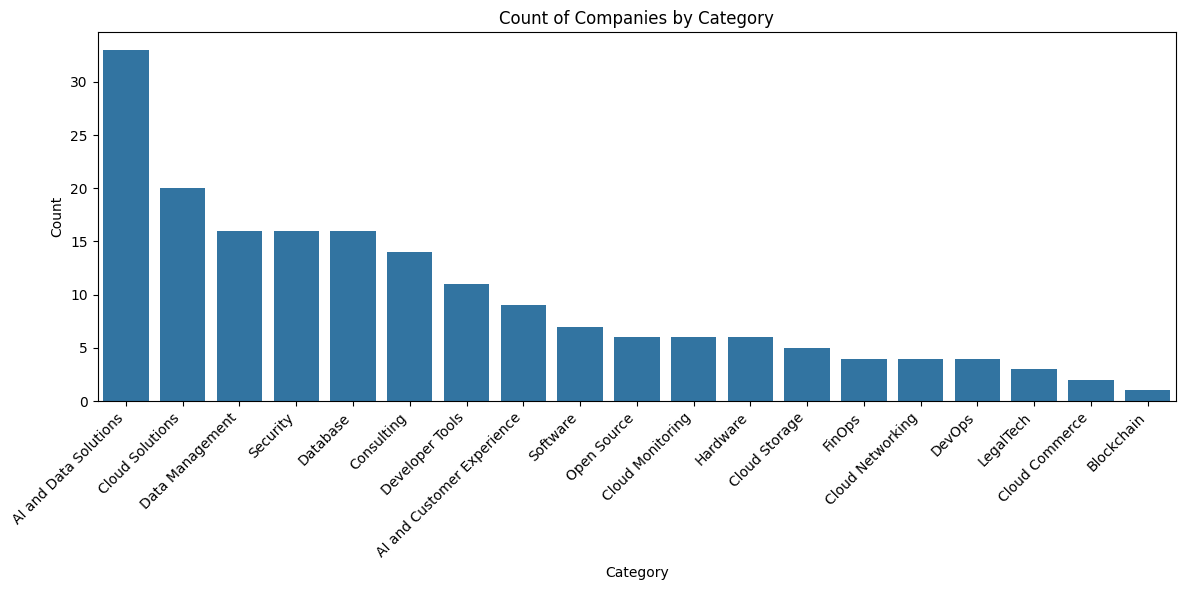

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cleaned is your DataFrame
# Load your DataFrame (example: df_cleaned = pd.read_csv('your_file.csv'))

# Plotting the count of entries by category
plt.figure(figsize=(12, 6))  # Set the figure size for better readability
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)

plt.title('Count of Companies by Category')  # Title of the plot
plt.xlabel('Category')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.xticks(rotation=45, ha="right")  # Rotate category names for better visibility
plt.tight_layout()  # Adjust subplot parameters for the plot to fit into the figure area

# Show the plot
plt.show()

## Generate subtitle in TTML format

In [ ]:
ttml_content = """
<tt xml:lang="en" xmlns="http://www.w3.org/ns/ttml" xmlns:ttp="http://www.w3.org/ns/ttml#parameter" ttp:timeBase="media" xmlns:tts="http://www.w3.org/ns/ttml#styling">
  <head>
    <styling>
      <style xml:id="s1" tts:fontFamily="Arial" tts:fontSize="16px" tts:fontWeight="bold" tts:color="white" tts:backgroundColor="rgba(0,0,255,0.5)" tts:textAlign="center"/>
      <style xml:id="s2" tts:fontFamily="Arial" tts:fontSize="16px" tts:color="yellow" tts:textAlign="center"/>
    </styling>
  </head>
  <body>
"""

# Loop through each row to add subtitles
for index, row in df.iterrows():
    ttml_content += f"""
    <div style="s3 s4">
      <p begin="{row['startTimestamp_subtitle']}" end="{row['endTimestamp_subtitle']}" style="s1">{row['companyName']} ({row['category']})<br/>{row['businessModel']}</p>
    </div>
"""

# Closing the TTML content
ttml_content += """
  </body>
</tt>
"""

# Print or write to a file
print(ttml_content)  # For demonstration, printing the output